In [3]:
%%time
from sklearn import tree
import pandas as pd
#import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Wall time: 0 ns


In [4]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:10% !important; height:10% !important;}</style>"
HTML(style)


In [5]:
#https://www.kaggle.com/c/titanic
titanic = pd.read_csv('data/titanic.csv')
titanic.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
#Поиск пропущенных значений
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
#удалим столбцы(axis=1) полей из таблицы
X = titanic.drop(['PassengerId','Survived','Name','Ticket','Cabin'],axis = 1)

#заменяем строковые данные разбивая их на столбцы
X = pd.get_dummies(X)

#грубо заполняем пропущенные значения
X = X.fillna({'Age':X.Age.median()})

#будем предсказывать выживание
y = titanic.Survived


In [8]:
clf = tree.DecisionTreeClassifier(criterion='entropy',
                                  max_depth=5)

In [9]:
clf.fit(X,y)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

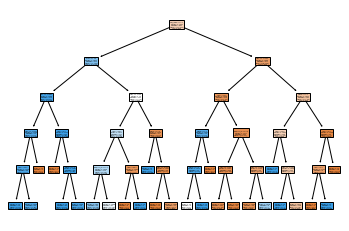

In [10]:
'''
#!pip install graphviz
#!pip install python-graphviz
#!pip install pydot 

graph = Source(
    tree.export_graphviz(clf,
                         out_file=None,
                         feature_names=list(X),
                         class_names=['Died','Survived'],
                         filled=True))
display(SVG(graph.pipe(format='svg')))

'''
#plt.hist(clf.predict(X))
#plt.show()
tree.plot_tree(clf, 
               feature_names=list(X), 
               class_names=['Died','Survived'],  
               filled=True );

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.33,random_state=42)

In [12]:
print(clf.score(X,y))

0.8496071829405163


In [13]:
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))


0.8406040268456376
0.8101694915254237


In [14]:
clf5 = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf5.fit(X_train,y_train)
print(clf5.score(X_train,y_train))
print(clf5.score(X_test,y_test))

0.8406040268456376
0.8067796610169492


In [17]:
from sklearn.model_selection import cross_val_score

max_depth_range = range(1,50)
score_data = pd.DataFrame()
for d in max_depth_range:
    clfd = tree.DecisionTreeClassifier(criterion='entropy', max_depth=d)
    clfd.fit(X_train,y_train)
    trn = clfd.score(X_train,y_train)
    tst = clfd.score(X_test,y_test)
    crs = cross_val_score(clfd,X_train,y_train,cv=5).mean()
    df = pd.DataFrame({'depth':[d],
                       'train':[trn],
                       'test':[tst],
                       'cross_val':[crs]})
    score_data = score_data.append(df)   


In [18]:
#изменение формата
score_data_long = pd.melt(score_data,
                          id_vars=['depth'],
                          value_vars=['train','test','cross_val'],
                          var_name='type',value_name='score')
                          


In [19]:
score_data_long.head(2)

,depth,type,score
0,1,train,0.781879
1,2,train,0.805369


<AxesSubplot:xlabel='depth', ylabel='score'>

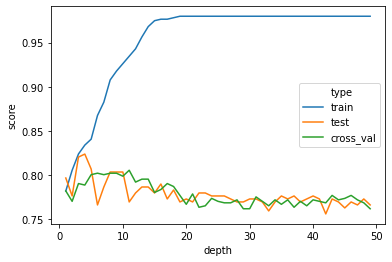

In [20]:
sns.lineplot(x='depth', y='score',hue='type',
             data=score_data_long)

In [21]:
#Данные все равно переобучены
from sklearn.model_selection import cross_val_score

In [22]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [23]:
#Разбили выборку на 5 частей и 
#поочередно обучаемся в режиме кроссвалидации 4+1
cross_val_score(clf,X_train,y_train,cv=5)

array([0.76666667, 0.82352941, 0.78991597, 0.75630252, 0.80672269])

In [24]:
#На графике кросвалидации лучшее обучение (максимум функции обучения)
#происходит на более большем шаге.
clf_best = tree.DecisionTreeClassifier(criterion='entropy', max_depth=10)
print(cross_val_score(clf_best,X_test,y_test,cv=5).mean())

clf_best.fit(X_train,y_train)
print(clf_best.score(X_test,y_test))

0.7864406779661017
0.8


In [53]:
from sklearn.model_selection import GridSearchCV
clf_opt = tree.DecisionTreeClassifier()
param_opt = {'criterion':['gini','entropy'],
             'max_depth':range(1,30)}

In [54]:
grid_search_cv_clf_opt = GridSearchCV(clf_opt,
                                      param_opt,
                                      cv=5)

In [55]:
grid_search_cv_clf_opt.fit(X_train,y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 30)})

In [56]:
grid_search_cv_clf_opt.best_params_

{'criterion': 'entropy', 'max_depth': 10}

In [57]:
best_clf = grid_search_cv_clf_opt.best_estimator_

In [58]:
best_clf

DecisionTreeClassifier(criterion='entropy', max_depth=10)

In [59]:
best_clf.score(X_test,y_test)

0.7932203389830509

In [60]:
from sklearn.metrics import precision_score, recall_score
y_pred = best_clf.predict(X_test)

In [61]:
precision_score(y_test,y_pred)

0.8041237113402062

In [62]:
recall_score(y_test,y_pred)

0.65